<a href="https://colab.research.google.com/github/ryangithubaccount/DSA2000/blob/main/CS101_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Imports and Data Loading

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import copy
import numpy as np
import pandas as pd
import sklearn.metrics as sk
import time


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
DEBUG = False
save_model = True
load_model = True
save_epoch = 10

data_file = '/content/drive/MyDrive/CS 101 Group/unet/data/rfi_data.npy'
label_file = '/content/drive/MyDrive/CS 101 Group/unet/data/rfi_labels.npy'

results_file = '/content/drive/MyDrive/CS 101 Group/unet/results/unet_results.csv'
model_file = '/content/drive/MyDrive/CS 101 Group/unet/model/unet_flattened_softmax'
best_model_file = '/content/drive/MyDrive/CS 101 Group/unet/model/working_unet_model'
grid_search_folder = '/content/drive/MyDrive/CS 101 Group/unet/grid_search/'

cuda:0


In [ ]:
#@title Loader Definition
def load_data(train_dataset, labels,
                      batch_size):

    tensor_x = torch.Tensor(train_dataset) # transform to torch tensor
    tensor_y = torch.Tensor(labels)

    train_dataset = TensorDataset(tensor_x,tensor_y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    return train_dataset, train_loader

# U-Net Model

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5, kernel_size=3):
        '''
        Double convolution block for U-Net, includes two convolutions with ReLU activation in between

        Args:

        `in_channels`: number of input channels

        `out_channels`: number of output channels

        `kernel_size`: size of convolution kernel

        `dropout`: dropout probability
        '''
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)
        # self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1)
        # self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv1(x)
        # x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        # x = self.batchnorm2(x)
        out = self.relu2(x)
        out = self.dropout2(out)
        return out


class DownConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5, kernel_size=3, pool_kernel=2, pool_stride=2):
        '''
        Down convolution block for U-Net, includes DoubleConv block and max pooling

        Args:

        `in_channels`: number of input channels

        `out_channels`: number of output channels

        `kernel_size`: size of convolution kernel

        `pool_kernel`: size of max pooling kernel

        `pool_stride`: stride used for max pooling

        `dropout`: dropout probability
        '''

        super(DownConvBlock, self).__init__()
        self.double_conv = DoubleConv(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            dropout=dropout
            )
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)

    def forward(self, x):
        double_conv = self.double_conv(x)
        out = self.pool(double_conv)
        if DEBUG:
          print(out.shape)
        return double_conv, out


class DownSample(nn.Module):
    def __init__(self, depth, channel_multiplier, initial_channel_size, pool_kernel=2, pool_stride=2, double_conv_kernel=3, dropout=0.5):
        '''
        Downsample block for U-Net, includes multiple DownConvBlocks

        Args:

        `depth`: number of down convolution blocks

        `channel_multiplier`: factor to scale channels by

        `initial_channel_size`: number of channels in first convolution

        `pool_kernel`: size of max pooling kernel

        `pool_stride`: stride used for max pooling

        `double_conv_kernel`: size of convolution kernel

        `dropout`: dropout probability
        '''
        super(DownSample, self).__init__()
        self.down_convs = nn.ModuleList([DownConvBlock(
            1, initial_channel_size,
            pool_kernel=pool_kernel,
            pool_stride=pool_stride,
            kernel_size=double_conv_kernel,
            dropout=dropout,
            )])
        self.down_convs.extend([
            DownConvBlock(
                initial_channel_size * (channel_multiplier ** i), initial_channel_size * (channel_multiplier ** (i + 1)), pool_kernel=pool_kernel,
                pool_stride=pool_stride,
                kernel_size=double_conv_kernel,
                dropout=dropout)
            for i in range(depth)])


    def forward(self, x):
        '''
        Args:

        `x`: output of last down convolution block

        Returns:

        `down_conv_tensors`: list of tensors from each down convolution block in downsampling layer order, i.e. decreasing resolution (used for upsampling)

        `x` (tensor): resulting mapping at bottom of U-Net after applying down convolutions
        '''
        if DEBUG:
          print('----------------- Downsampling -----------------')
        down_conv_tensors = []
        for down_conv in self.down_convs:
            copy, x = down_conv(x)
            down_conv_tensors.append(copy)
            if DEBUG:
              print(x.shape)

        return down_conv_tensors, x


class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3,
                 conv_stride=2, dropout=0.5):
        '''
        Up convolution block for U-Net, includes up convolution, concatenation, and DoubleConv block

        Args:

        `in_channels`: number of input channels

        `out_channels`: number of output channels

        `kernel_size`: size of convolution kernel

        `conv_stride`: stride used for convolution

        `dropout`: dropout probability
        '''

        super(UpConvBlock, self).__init__()
        self.up_conv = nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=conv_stride,
            )
        self.dropout = nn.Dropout(dropout)
        self.double_conv = DoubleConv(out_channels * 2, out_channels)


    def forward(self, x, down_tensor, output_size=None):
        '''

        Args:

        `x` (tensor): input mapping

        `down_tensor`: corresponding mapping from downsampling section of U-Net

        `output_size`: the size to target to match the down_tensor skip connection size

        Returns:

        `out` (tensor): resulting mapping after one layer of upsampling
        '''
        out = self.up_conv(x, output_size)
        out = self.dropout(out)

        if down_tensor.shape != out.shape:
          print(f'tensors of different shapes on upsample: down => ({down_tensor.shape}) vs up => ({out.shape})')
        assert(down_tensor.shape == out.shape)

        out = torch.cat([down_tensor, out], dim=1)
        out = self.double_conv(out)

        return out


class UpSample(nn.Module):
    def __init__(self, depth, channel_multiplier, initial_channel_size, up_conv_kernel=2, up_conv_stride=2, dropout=0.5):
        '''
        Upsample block for U-Net, includes multiple UpConvBlocks

        Args:

        `depth`: number of up convolution blocks

        `channel_multiplier`: factor to scale channels by

        `initial_channel_size`: number of channels in first convolution

        `up_conv_kernel`: size of up convolution kernel

        `up_conv_stride`: stride used for up convolution

        `dropout`: dropout probability
        '''

        super(UpSample, self).__init__()
        self.up_convs = nn.ModuleList([UpConvBlock(
            initial_channel_size * (channel_multiplier ** (depth + 1)), initial_channel_size * (channel_multiplier ** depth),
            conv_stride=up_conv_stride,
            kernel_size=up_conv_kernel,
            dropout=dropout,
            )])
        self.up_convs.extend([
            UpConvBlock(
                initial_channel_size * (channel_multiplier ** (i + 1)), initial_channel_size * (channel_multiplier ** (i)),
                conv_stride=up_conv_stride,
                kernel_size=up_conv_kernel,
                dropout=dropout)
            for i in reversed(range(depth))])

    def forward(self, x, down_conv_tensors):
        '''
        Args:
        `x` (tensor): input mapping

        `down_conv_tensors`: list of tensors resulting from downsampling in top-down order, i.e. decreasing resolution
        '''
        if DEBUG:
          print('----------------- Upsampling -----------------')
          print(x.shape)
        for i, up_conv in enumerate(self.up_convs):
            skip = down_conv_tensors[-(i+1)]
            x = up_conv(x, skip, output_size=skip.shape)
            if DEBUG:
              print(x.shape)
        return x

class UNet(nn.Module):
    def __init__(self, dropout=0.5, depth=4, channel_multiplier=2, initial_channel_size=64, pool_kernel=2, pool_stride=2, double_conv_kernel=3, up_conv_kernel=2, up_conv_stride=2) -> None:
        '''
        Model for U-Net implementation for RFI segmentation

        Args:

        `image_size`: size of input image

        `depth`: number of down and up convolutions in the model (after the first one)

        `channel_multiplier`: factor to scale channels by

        `initial_channel_size`: number of channels in first convolution

        `pool_kernel`: size of max pooling kernel

        `pool_stride`: stride used for max pooling

        `double_conv_kernel`: size of convolution kernel

        `up_conv_kernel`: size of up convolution kernel

        `up_conv_stride`: stride used for up convolution

        `dropout`: dropout probability
        '''
        super(UNet, self).__init__()
        self.down_sample = DownSample(
            depth,
            channel_multiplier,
            initial_channel_size,
            pool_kernel=pool_kernel,
            pool_stride=pool_stride,
            double_conv_kernel=double_conv_kernel,
            dropout=dropout
            )

        self.bottom_conv = DoubleConv(initial_channel_size * (channel_multiplier ** depth), initial_channel_size * (channel_multiplier ** (depth + 1)), kernel_size=double_conv_kernel)

        self.up_sample = UpSample(
            depth,
            channel_multiplier,
            initial_channel_size,
            up_conv_kernel=up_conv_kernel,
            up_conv_stride=up_conv_stride,
            dropout=dropout
            )

        self.end_conv = nn.Conv2d(
            initial_channel_size,
            2,
            kernel_size=1) # 2 classes: RFI and not RFI

        self.softmax = nn.Softmax(dim=1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, image):
        '''
        Returns a mask for the image (flattened) where each pixel represents the probability that that pixel is RFI.
        0 means not RFI and 1 means definitely RFI.

        Args:

        `image` (tensor): input image in format (B, N, H, W) where B is batch size, N is number of channels, H is height, and W is width

        '''
        if DEBUG:
          print('----------------- Starting Shape -----------------')
          print(image.shape)

        # Encoding information
        residual_convs, out = self.down_sample(image)
        # Bottom of U-Net
        if DEBUG:
          print('----------------- Bottom of U-Net -----------------')
        out = self.bottom_conv(out)
        if DEBUG:
          print(out.shape)
        # Decoding information
        out = self.up_sample(out, residual_convs)
        # Final convolution
        if DEBUG:
          print('----------------- Final Mask -----------------')
        out = self.end_conv(out)
        out = self.softmax(out)
        if DEBUG:
          print(out.shape)

        out = out[:,0:1,:,:].view(out.size(0), 1, -1) # Says to return how sure the model is that the pixel is RFI (WLOG chose 0th index to be RFI)
        return out


        def predict_proba(x):
          return self.forward(x)

# Running Code

In [ ]:
#@title Hyperparameters
num_epochs = 5
train_split = 0.7
val_split = 0.85
batch_size = 64
learning_rate = 0.001
depth = 2
initial_channel_size = 128
channel_multiplier = 2
dropout = 0.2
pool_kernel_size = 2
pool_stride = 2
double_conv_kernel_size = 3
up_conv_kernel_size = 2
up_conv_stride = 2

In [ ]:
#@title Losses and Scores
def f1_score ( threshold, y_pred, y_true ):
    bc_pred = (y_pred > threshold).astype(int)
    tp = np.sum(np.logical_and(bc_pred == 1, y_true == 1))
    fp = np.sum(bc_pred == 1) - tp
    fn = np.sum(np.logical_and(bc_pred == 0, y_true == 1))

    precision = 0
    if tp != 0:
      precision = tp / (tp + fp)
    recall = 0
    if tp != 0:
      recall = tp / (tp + fn)
    f1 = 0
    if precision != 0 and recall != 0:
      f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

def inference(model, data_loader, device):
    flag = False
    y_true = None
    y_pred = None
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            if flag:
              y_true = np.concatenate((y_true, labels.cpu()))
              y_pred = np.concatenate((y_pred, outputs.cpu()))
            else:
              y_true = np.array(labels.cpu())
              y_pred = np.array(outputs.cpu())
              flag = True
    return y_pred, y_true

def evaluate ( threshold, model, data_loader, device ):
    '''
    Calculate the classification error in (%)
    '''
    y_pred, y_true = inference(model, data_loader, device)
    return f1_score(threshold, y_pred, y_true)

def get_auc(model, test_loader, device):
    y_pred, y_true = inference(model, test_loader, device)
    y_true, y_pred = np.ndarray.flatten(y_true), np.ndarray.flatten(y_pred)
    return sk.roc_auc_score(y_true, y_pred)
# ---------------------------------

def l1_loss(output, target):
    loss = torch.mean(abs(output - target))
    return loss

def cross_entropy(output, target):
    -(target*np.log(output)).sum(axis=(0, 1))

def weighted_bce_loss(output, target):
    x = -torch.mean(1 / abs(target-0.95)*(target*(torch.log(output + 1e-20)) + (1 - target)*torch.log(1 - output + 1e-20)))
    return x

def f1_loss(y_pred, y_true):
    bc_pred = (y_pred > 0.5)
    tp = torch.sum(torch.where((bc_pred) & (y_true == 1), 1, 0))
    fp = torch.sum(torch.where(bc_pred, 1, 0)) - tp
    fn = torch.sum(torch.where((bc_pred == False) & (y_true == 1), 1, 0))
    return 1 - (tp / (tp + 1/2 * (fp+fn)))

In [ ]:
#@title Model Run Function
def run(model, epochs, train_loader, criterion, optimizer, RESULTS_PATH, threshold=0.5, test_loader=None, scheduler=None, MODEL_PATH=None):
    print("Starting to train...")
    start_time = time.time()
    col_names = ['epoch', 'train_loss', 'precision_train', 'recall_train', 'f1_score_train', 'precision_test', 'recall_test', 'f1_score_test', 'auc_score']
    results_df = pd.DataFrame(columns=col_names).set_index('epoch')
    best_err = torch.inf
    best_f1 = 0
    best_auc = 0
    best_err_model = "No model..."
    best_f1_model = "No model..."
    best_auc_model = "No model..."
    for epoch in range(int(epochs)):
        # print("epoch:", epoch)
        epoch_start = time.time()
        model.train()

        total_loss = []

        for i, data in enumerate(train_loader, 0):
            if i % 50 == 0:
              print('finished iteration', i)
            x, y = data
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            prediction = model(x)
            loss = criterion(prediction, y)

            loss.backward()
            optimizer.step()

            total_loss.append ( loss.item() )


        train_loss = np.mean(total_loss)
        precision_train, recall_train, f1_score_train = evaluate(0.5, model, train_loader, device)
        precision_test, recall_test, f1_score_test, auc = (0, 0, 0, 0)
        if test_loader != None:
          precision_test, recall_test, f1_score_test = evaluate(0.5, model, test_loader, device)
          auc = get_auc(model, test_loader, device)

        results_df.loc[epoch] = [train_loss, precision_train, recall_train, f1_score_train, precision_test, recall_test, f1_score_test, auc]
        results_df.to_csv ( RESULTS_PATH )
        print(f'({time.time() - epoch_start} s) epoch: {epoch+1} f1_train: {f1_score_train} f1_test:{f1_score_test} train_loss: {train_loss} auc_score: {auc}')

        if train_loss < best_err:
          best_err_model = copy.deepcopy(model)
          best_err = train_loss
        if f1_score_train > best_f1:
          best_f1_model = copy.deepcopy(model)
          best_f1 = f1_score_train
        if auc > best_auc:
          best_auc_model = copy.deepcopy(model)
          best_auc = auc

    torch.save(best_err_model, MODEL_PATH+'err')
    torch.save(best_f1_model, MODEL_PATH+'f1')
    torch.save(best_err_model, MODEL_PATH+'auc')
    print(f'Finished Training in {time.time() - start_time} seconds')

    return best_auc_model, best_f1_model, best_err_model

In [ ]:
# Using float32 instead of float64(double) because of type matching errors
dataset = torch.from_numpy(np.load(data_file)).float().to(device)
labels = torch.from_numpy(np.load(label_file)).float().to(device)

N = dataset.shape[0]
train_dataset = dataset[:int(N*train_split)]
train_labels = labels[:int(N*train_split)]
train_labels = train_labels.view(train_labels.size(0), 1, -1)

val_dataset = dataset[int(N*train_split):int(N*val_split)]
val_labels = labels[int(N*train_split):int(N*val_split)]
val_labels = val_labels.view(val_labels.size(0), 1, -1)

test_dataset = dataset[int(val_split*N):]
test_labels = labels[int(val_split*N):]
test_labels = test_labels.view(test_labels.size(0), 1, -1)


train_dataset = (train_dataset - torch.mean(train_dataset)) / torch.std(train_dataset)

_, train_loader = load_data(train_dataset[0:5000], train_labels[0:5000], batch_size)
_, val_loader = load_data(val_dataset, val_labels, 1)
_, test_loader = load_data(test_dataset, test_labels, batch_size)

print(dataset.shape)
print(labels.shape)

torch.Size([26200, 1, 100, 100])
torch.Size([26200, 1, 100, 100])


In [ ]:
model = UNet(
        depth=depth,
        initial_channel_size=initial_channel_size,
        dropout=dropout,
    ).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adadelta(params=model.parameters())

run(model, num_epochs, train_loader, criterion, optimizer, RESULTS_PATH=results_file, test_loader=test_loader, MODEL_PATH=model_file)

In [ ]:
model = torch.load(model_file+'err', device)
print(model)

# Working with Expert Data

In [ ]:
import pickle

lofar_data_file = '/content/drive/MyDrive/CS 101 Group/data/Expert Data/LOFAR_Full_RFI_dataset.pkl'

with open(lofar_data_file, 'rb') as f:
    data = pickle.load(f)

In [ ]:
model = torch.load(best_model_file, map_location=device)

dataset = torch.tensor(data[0]).float().to(device)
labels = torch.tensor(data[1]).float().to(device)
del data

N = dataset.shape[0]
train_dataset = dataset[:int(N*train_split)]
train_labels = labels[:int(N*train_split)]
train_labels = train_labels.view(train_labels.size(0), 1, -1)

val_dataset = dataset[int(N*train_split):int(N*val_split)]
val_labels = labels[int(N*train_split):int(N*val_split)]
val_labels = val_labels.view(val_labels.size(0), 1, -1)

test_dataset = dataset[int(val_split*N):]
test_labels = labels[int(val_split*N):]
test_labels = test_labels.view(test_labels.size(0), 1, -1)


train_dataset = (train_dataset - torch.mean(train_dataset)) / torch.std(train_dataset)

_, train_loader = load_data(train_dataset[0:5000], train_labels[0:5000], batch_size)
_, val_loader = load_data(val_dataset, val_labels, 1)
_, test_loader = load_data(test_dataset, test_labels, batch_size)

print(dataset.shape)
print(labels.shape)

# Model Calibration

In [ ]:
#@title Model Calibration
import sklearn.calibration as calibration

def get_probs(model, threshold, dataloader):
  '''
  Gets a list of the RFI of each pixel in `dataloader` as a flattened 1d tensor.
  Used for calibration.
  '''
  model.eval()
  with torch.no_grad():
    y_pred = torch.tensor([]).to(device)
    y_test = torch.tensor([]).to(device)
    for x, y in dataloader:
      x, y = x.to(device), y.to(device)
      output = model(x)
      y_pred = torch.cat([y_pred, output])
      y_test = torch.cat([y_test, y])


  return y_pred.view(-1).cpu(), y_test.view(-1).cpu()

In [ ]:
_, calib_loader = load_data(val_dataset, val_labels, 1)

In [ ]:
y_pred, y_test = get_probs(model, 0.5, calib_loader)

In [ ]:
base_prob_true, base_prob_pred = calibration.calibration_curve(y_test, y_pred, n_bins=10)

In [ ]:
print(base_prob_true.shape)

In [ ]:
#@title Calibration Plots
plt.plot(base_prob_pred, base_prob_true, marker='+', label='Model')
plt.plot([0,1],[0,1], linestyle='--', label='Perfect Calibration')
plt.legend()
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.show()

This graph shows that we are not as certain of RFI even when the model says that it is sure there is RFI. This implies that the model needs to be calibrated

# Data Visualization

In [ ]:
#@title Visualization Function

def visualize(threshold, model, dataloader):
  model.eval()
  for x, y in dataloader:
      x, y = x.to(device), y.to(device)
      output = model(x).cpu().detach().numpy().reshape(x.shape)
      bc_output = (output > threshold).astype(int)
      print(output[0][0])

      plt.imshow(x.cpu()[0][0])
      plt.xlabel('Time (samples)')
      plt.ylabel('Frequency (channel)')
      plt.title('Inputs')
      plt.show()

      plt.imshow(output[0][0])
      plt.xlabel('Time (samples)')
      plt.ylabel('Frequency (channel)')
      plt.title('U-Net Model Output')
      plt.show()

      plt.imshow(y.cpu()[0][0])
      plt.xlabel('Time (samples)')
      plt.ylabel('Frequency (channel)')
      plt.title('Labels')
      plt.show()

      plt.imshow(bc_output[0][0])
      plt.xlabel('Time (samples)')
      plt.ylabel('Frequency (channel)')
      plt.title('Binary Mask Prediction (U-Net)')
      plt.show()

In [ ]:
def loss_plots(train_loss, f1_loss):

  plt.plot(range(1, num_epochs + 1), train_loss, label="BCE Loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Model Loss over Time')

  plt.plot(range(1, num_epochs + 1), f1_loss, label="F1 Loss")
  plt.legend()

  plt.show()

In [ ]:
def tune_threshold(model, dataloader):
  optimal_threshold = 0
  best_f1 = 0
  f1s = np.zeros((100, 2))
  y_pred, y_true = inference(model, dataloader, device)
  for i in range(100):
    precision, recall, f1 = f1_score(i * 0.01, y_pred, y_true)
    f1s[i] = [i * 0.01, f1]
    if f1 > best_f1:
      best_f1 = f1
      optimal_threshold = i * 0.01
  plt.plot(f1s[:, 0], f1s[:, 1])
  print("best f1: ", best_f1)
  print("optimal threhold: ", optimal_threshold)
  return optimal_threshold

In [ ]:
#@title Loading test data
old_data_file = '/content/drive/MyDrive/CS 101 Group/data/real_rfi_data.npy'
old_label_file = '/content/drive/MyDrive/CS 101 Group/data/real_rfi_labels.npy'

old_dataset = torch.from_numpy(np.load(old_data_file)).float().to(device)
old_labels = torch.from_numpy(np.load(old_label_file)).float().to(device)

sample = old_dataset[(543, 11851, 11759, 10359, 12546),:,:]
sample_labels = old_labels[(543, 11851, 11759, 10359, 12546),:,:]

old_sample, old_sample_loader = load_data(sample, sample_labels, 1)

sample = dataset[(200, 205),:,:]
sample_labels = labels[(200, 205), :, :]

sample, sample_loader = load_data(sample, sample_labels, 1)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 7.8031500e-37]
 [0.0000000e+00 0.0000000e+00 2.9427268e-44 ... 4.3456947e-21
  3.6169709e-30 1.7780898e-28]
 [4.1058045e-43 1.8004749e-12 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


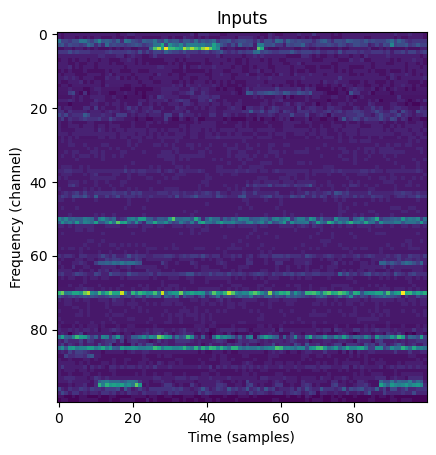

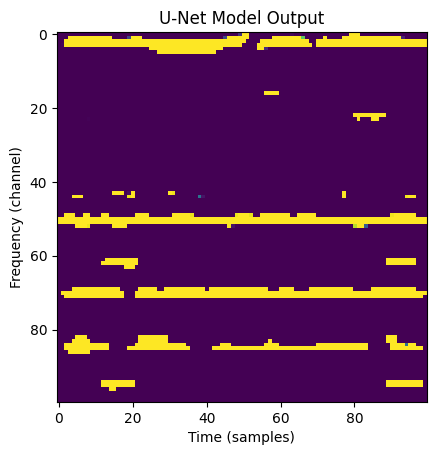

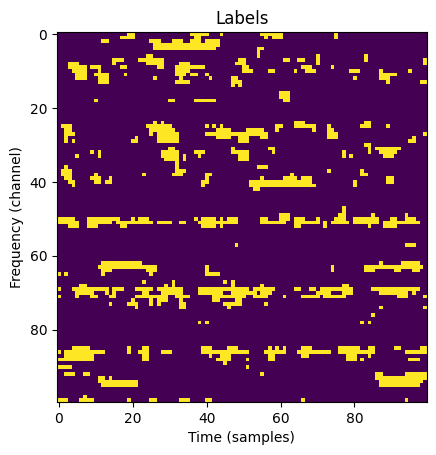

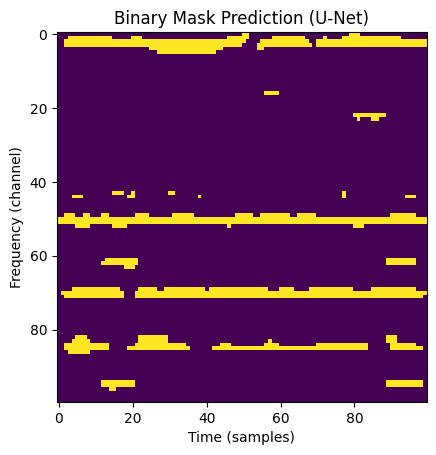

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


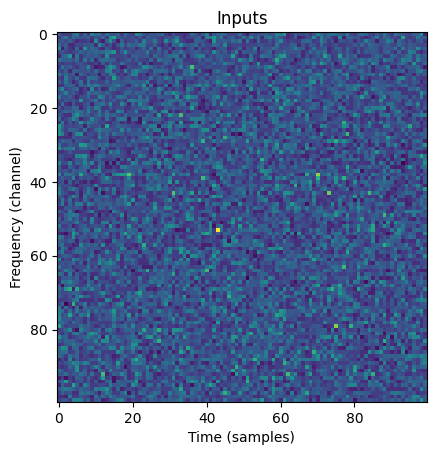

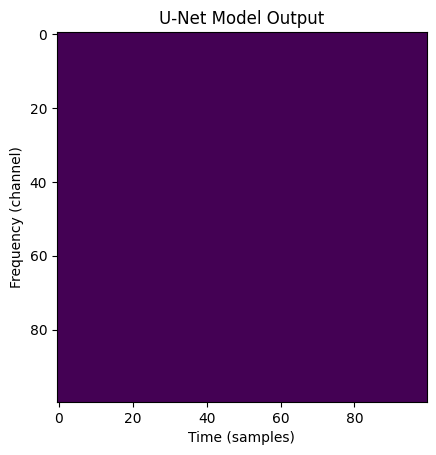

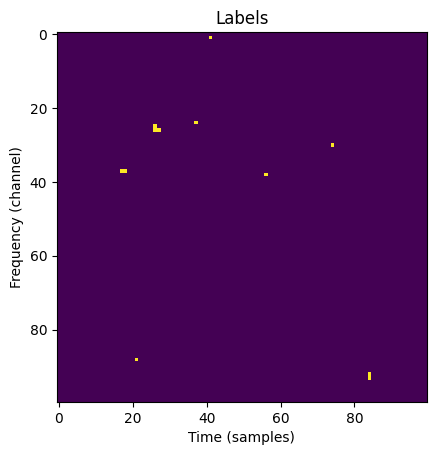

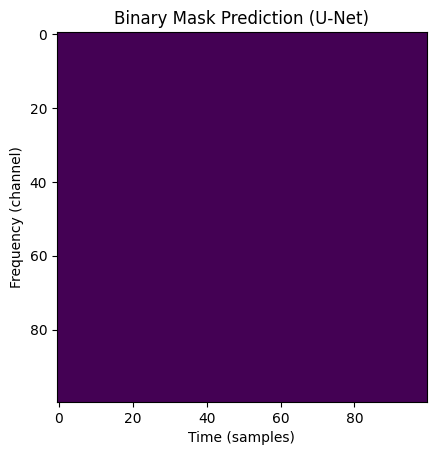

[[1.7599748e-02 1.7262010e-03 6.3484017e-04 ... 2.2143258e-03
  1.2140821e-02 7.4081697e-02]
 [2.1303704e-03 6.7760171e-05 1.9942994e-05 ... 2.1711825e-05
  5.3080317e-04 1.5855826e-02]
 [1.2649869e-03 4.5667301e-05 2.5526073e-05 ... 6.2623121e-07
  3.9273316e-05 4.0231622e-03]
 ...
 [1.0572809e-03 4.7768331e-06 9.4159091e-08 ... 3.2027192e-10
  6.7341773e-08 1.0390037e-04]
 [7.5002625e-03 1.6226151e-04 8.5417414e-06 ... 7.7317665e-08
  5.1064576e-06 1.1197403e-03]
 [6.0204681e-02 8.5499315e-03 1.7610565e-03 ... 1.3519025e-04
  1.2006682e-03 2.1995205e-02]]


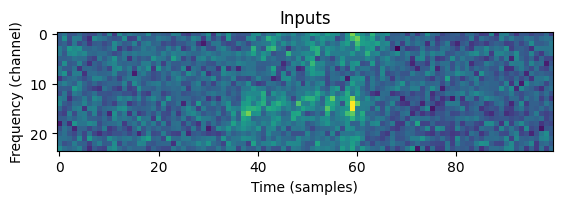

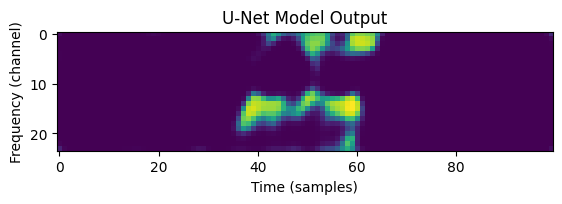

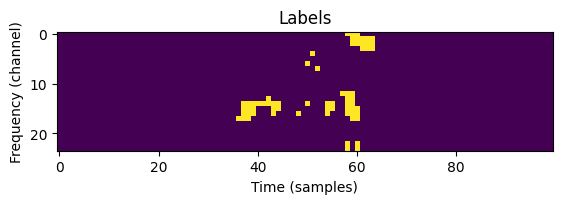

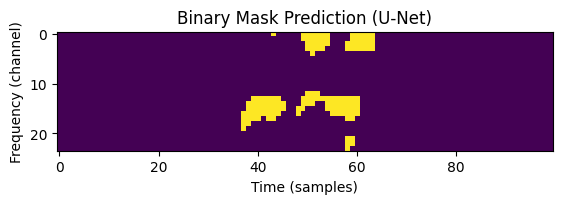

[[1.71415899e-02 1.29069097e-03 4.75181441e-04 ... 2.41512945e-03
  5.86611405e-03 3.83233428e-02]
 [1.51527417e-03 1.82671138e-05 3.25036581e-06 ... 4.88791266e-05
  1.91749350e-04 5.09076798e-03]
 [5.85511967e-04 3.28785836e-06 3.12441728e-07 ... 1.02140766e-05
  4.05407227e-05 1.77814090e-03]
 ...
 [2.56280508e-02 4.53283638e-03 4.23832797e-03 ... 1.08437614e-08
  1.86408855e-07 8.15561798e-05]
 [3.96898948e-02 9.90323443e-03 1.10160336e-02 ... 1.09271674e-07
  1.45512229e-06 2.85166170e-04]
 [1.10154279e-01 5.44437543e-02 5.46055250e-02 ... 7.82998541e-05
  3.57325742e-04 7.55303260e-03]]


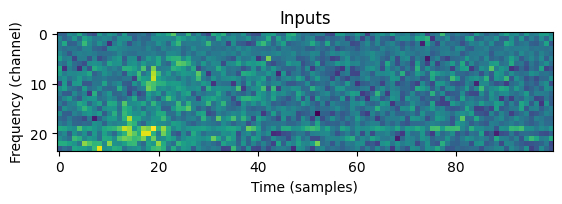

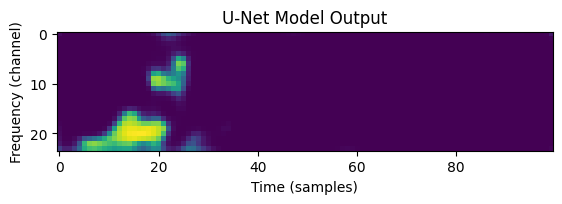

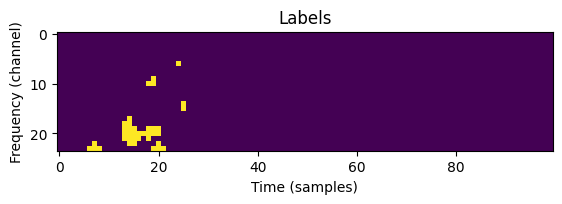

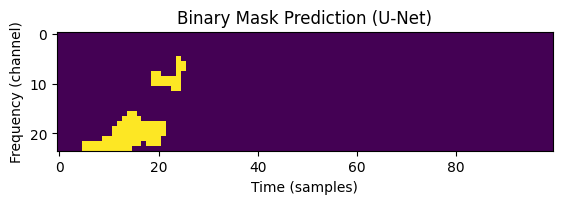

[[0.2154254  0.1912634  0.25988728 ... 0.23180917 0.18964435 0.21809727]
 [0.13930443 0.11556724 0.21203268 ... 0.13917214 0.09046758 0.11981393]
 [0.09743039 0.07449382 0.1658366  ... 0.03983564 0.01927813 0.04250092]
 ...
 [0.01269177 0.00251965 0.00456806 ... 0.01816225 0.03358355 0.0934384 ]
 [0.0151705  0.0036867  0.00742257 ... 0.040621   0.05271148 0.11091444]
 [0.05630698 0.02619544 0.04070229 ... 0.12394783 0.13411708 0.19201927]]


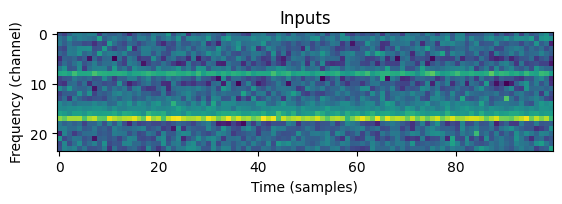

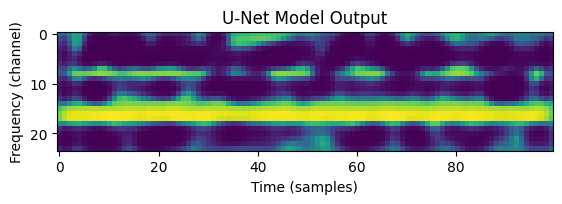

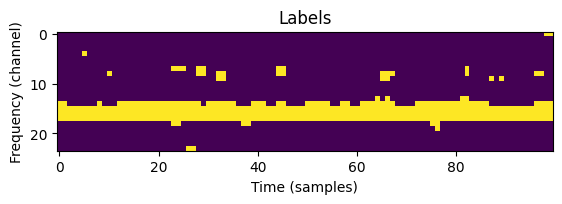

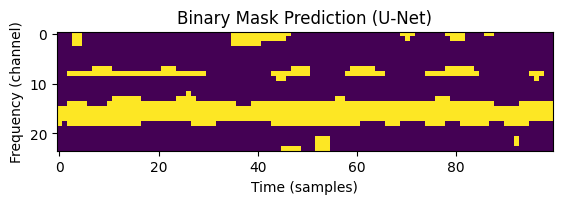

[[2.5976345e-02 1.7087660e-03 2.4071860e-04 ... 7.4506264e-05
  1.9800062e-03 3.5488255e-02]
 [4.6239691e-03 5.5236098e-05 1.9461525e-06 ... 2.6831870e-07
  4.9576531e-05 6.2378943e-03]
 [2.6681735e-03 1.6875147e-05 3.4647860e-07 ... 4.7868838e-08
  1.8591900e-05 3.8626883e-03]
 ...
 [4.0788953e-05 5.6354452e-08 2.6585949e-09 ... 9.5682673e-10
  3.1729357e-07 2.2362734e-04]
 [1.0309760e-04 2.5034561e-07 1.5127492e-08 ... 1.3169222e-07
  2.2659904e-05 3.0262666e-03]
 [2.7730048e-03 6.3037987e-05 1.2218332e-05 ... 1.7251102e-04
  3.4266976e-03 4.6249516e-02]]


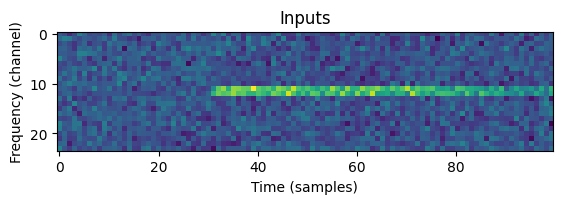

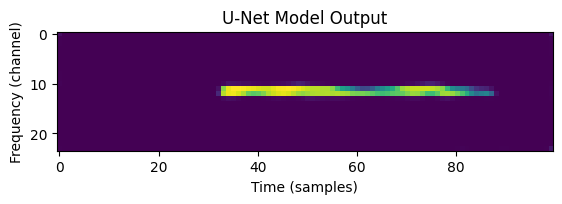

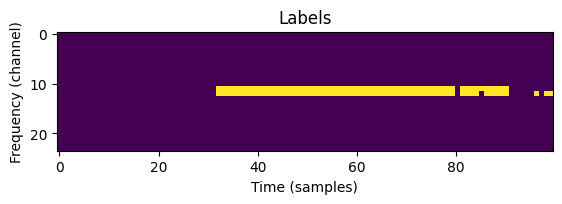

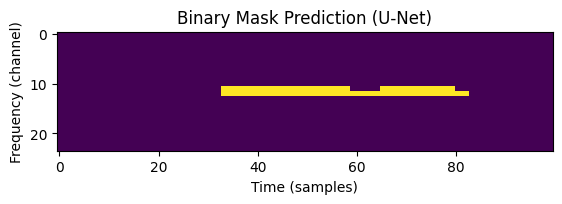

[[0.17290549 0.09749243 0.07519988 ... 0.09502683 0.08605898 0.1540683 ]
 [0.09514689 0.03660338 0.02384544 ... 0.04594012 0.04105707 0.09623742]
 [0.07586551 0.02538957 0.01596631 ... 0.06673323 0.05520911 0.11138969]
 ...
 [0.10685705 0.03878547 0.02634127 ... 0.03456389 0.06664468 0.14940815]
 [0.14295103 0.06508764 0.05113149 ... 0.04950776 0.08955984 0.17510201]
 [0.22522588 0.15453415 0.13739066 ... 0.12612997 0.1723156  0.24805328]]


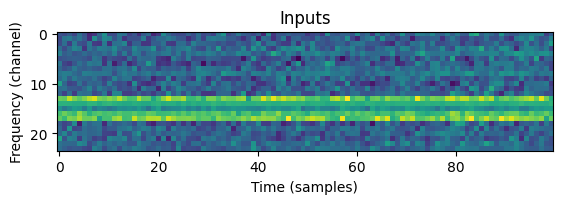

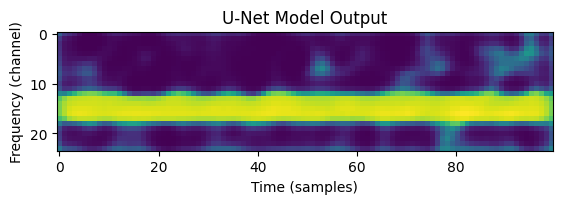

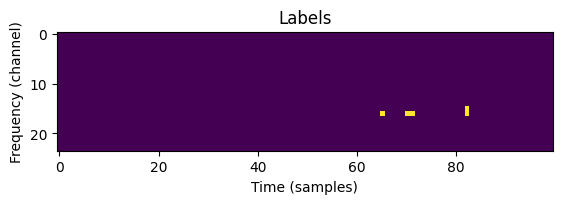

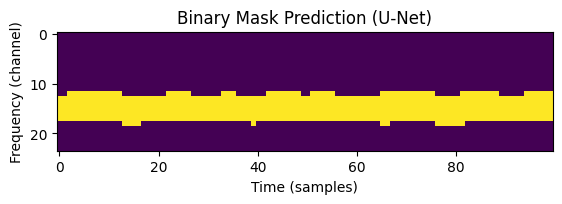

In [ ]:
#@title Vizualize Trained Model Best Training Error
best_err_model = torch.load(model_file+'err', map_location=device)
# opt_threshold = tune_threshold(best_err_model, sample_loader)

visualize(0.3, best_err_model, sample_loader)
visualize(0.3, best_err_model, old_sample_loader)

[[7.12210033e-03 5.43224160e-04 2.78863998e-04 ... 1.14681909e-03
  2.10855668e-03 1.50295021e-02]
 [6.12870557e-04 1.06073485e-05 4.10100665e-06 ... 2.72890993e-05
  6.59772923e-05 1.56050059e-03]
 [2.78188993e-04 2.67621795e-06 7.45709031e-07 ... 5.67400866e-06
  1.25758343e-05 5.91287506e-04]
 ...
 [2.82164384e-02 6.04355102e-03 6.28784904e-03 ... 3.97708864e-05
  8.06285534e-05 1.66714657e-03]
 [4.63855267e-02 1.33270714e-02 1.33589441e-02 ... 1.46609833e-04
  2.01964736e-04 3.01467138e-03]
 [8.75958055e-02 3.32524963e-02 3.09908446e-02 ... 3.06143565e-03
  3.58570088e-03 2.00297907e-02]]


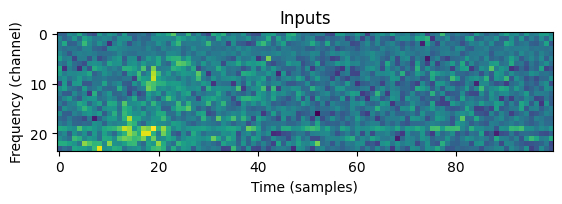

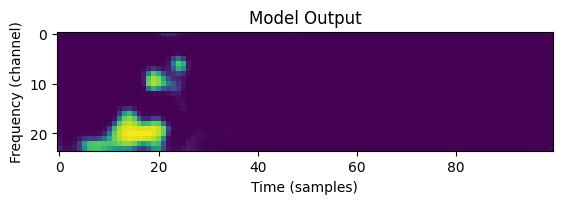

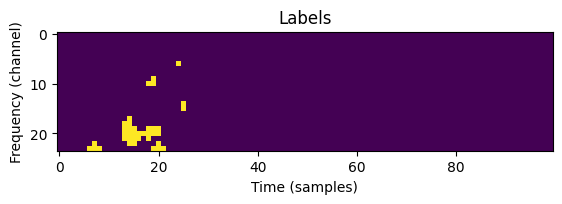

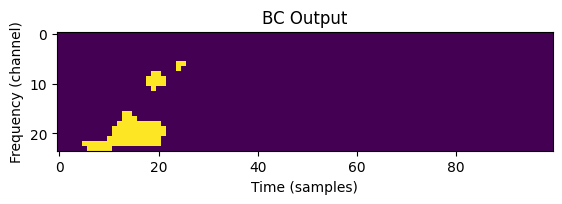

[[1.0542357e-01 8.0357708e-02 1.6068703e-01 ... 2.6421455e-01
  3.1153488e-01 3.1801939e-01]
 [5.7713687e-02 4.0850703e-02 1.1452135e-01 ... 1.5881278e-01
  1.7610708e-01 2.1290049e-01]
 [3.7468608e-02 2.3900663e-02 8.0022231e-02 ... 2.3394812e-02
  2.4895832e-02 6.0143594e-02]
 ...
 [2.0894799e-03 1.9596149e-04 3.1132827e-04 ... 7.6845093e-03
  9.7084176e-03 3.1487990e-02]
 [4.6556294e-03 6.5186841e-04 1.2798352e-03 ... 2.0334328e-02
  1.9141393e-02 4.5469366e-02]
 [3.0979086e-02 9.6128201e-03 1.4837551e-02 ... 4.6710528e-02
  4.6796676e-02 9.0389572e-02]]


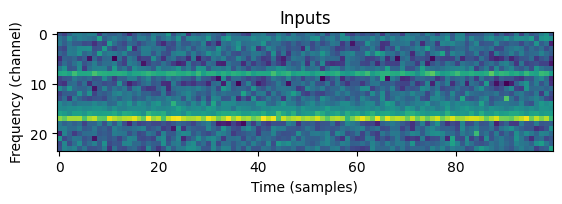

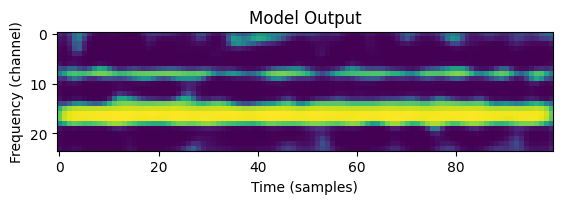

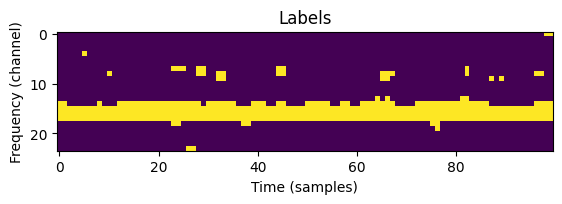

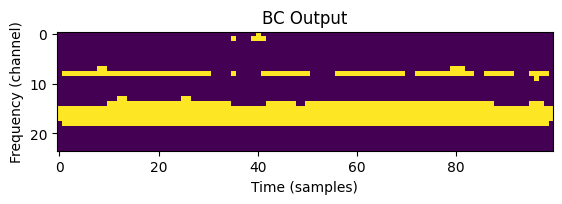

[[2.4194064e-02 2.3080222e-03 5.3869013e-04 ... 3.3745222e-04
  1.1358287e-03 1.2780486e-02]
 [5.7432610e-03 2.1097998e-04 2.7111439e-05 ... 7.2838789e-06
  4.7018653e-05 1.9900734e-03]
 [3.9083394e-03 1.3148351e-04 2.1880274e-05 ... 2.2225729e-06
  2.1550348e-05 1.2811073e-03]
 ...
 [1.0870897e-03 3.1478816e-05 1.0570118e-05 ... 4.3483369e-06
  1.8432394e-05 9.8373985e-04]
 [2.0294047e-03 8.2736267e-05 3.1657819e-05 ... 1.1962873e-05
  6.6648929e-05 2.4370991e-03]
 [1.3580642e-02 1.5761445e-03 8.1155845e-04 ... 3.5806370e-04
  1.4034122e-03 1.6415069e-02]]


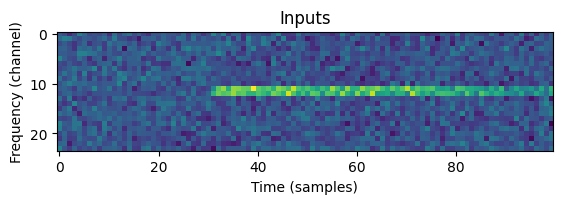

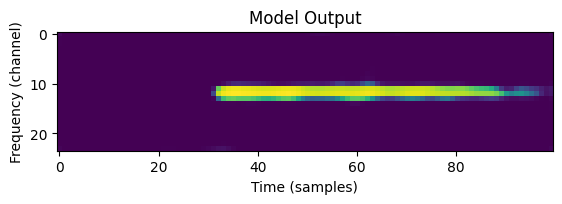

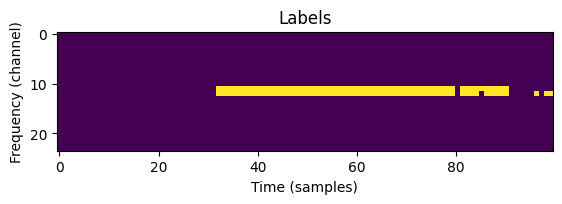

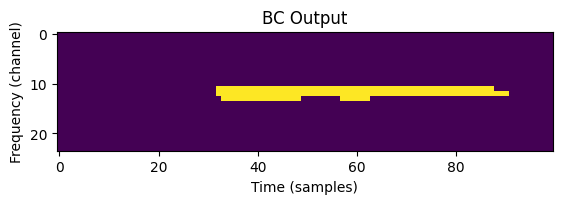

[[0.02987671 0.00556059 0.00335627 ... 0.01407685 0.01117699 0.03868187]
 [0.00590499 0.00048777 0.00024933 ... 0.00322725 0.0025683  0.01472623]
 [0.00353841 0.00024192 0.00013114 ... 0.00420402 0.00370402 0.01887615]
 ...
 [0.01204844 0.00145871 0.00068108 ... 0.00019208 0.00046482 0.00583681]
 [0.01824955 0.0026253  0.00129724 ... 0.00038535 0.00086316 0.008758  ]
 [0.0503716  0.01252006 0.00772057 ... 0.00425017 0.00739121 0.03575492]]


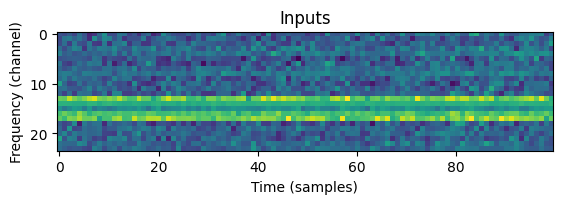

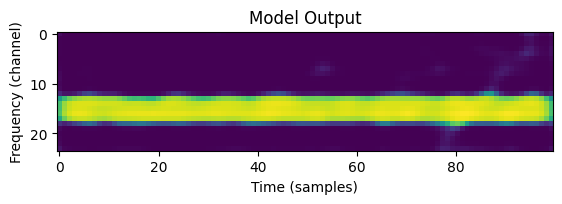

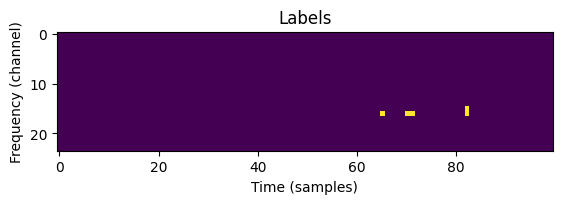

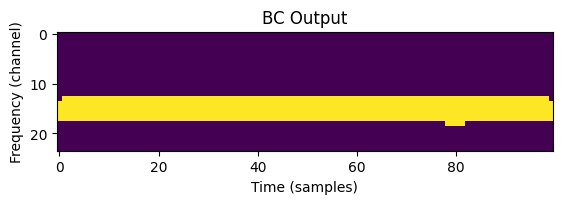

In [ ]:
#@title Vizualize Trained Model Best F1 Score

best_f1_model = torch.load(model_file+'f1', map_location=device)
visualize(0.5, best_f1_model, sample_loader)

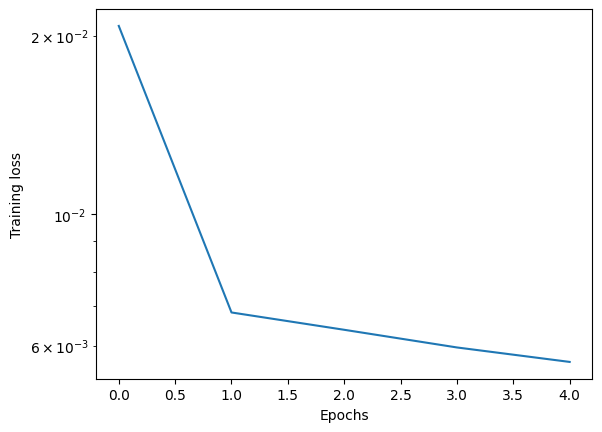

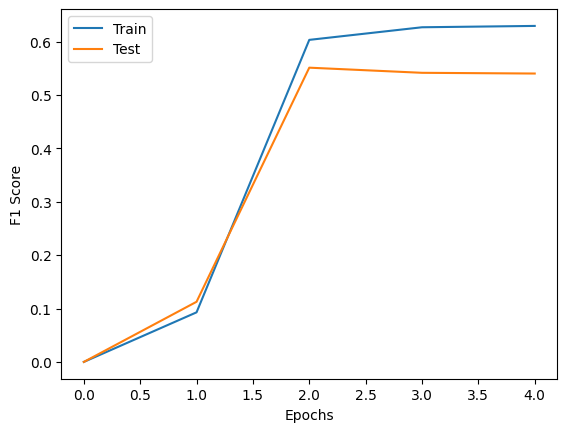

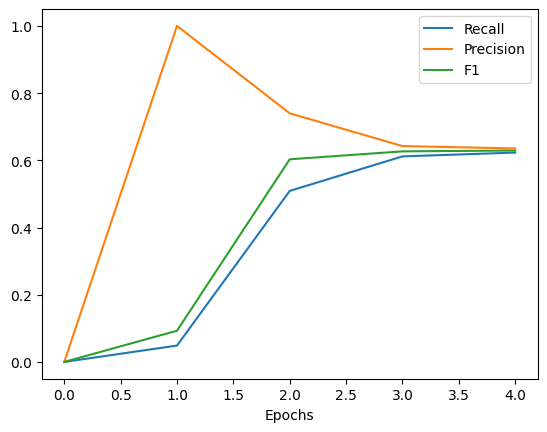

In [ ]:
#@title Plotting Loss Curves

def plot_curves(losses):
  plt.figure()
  plt.plot(losses['epoch'], losses['train_loss'])
  plt.xlabel("Epochs")
  plt.ylabel("Training loss")
  plt.yscale("log")
  plt.show()

  plt.figure()
  plt.plot(losses['epoch'], losses['f1_score_train'], label="Train")
  plt.plot(losses['epoch'], losses['f1_score_test'], label="Test")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("F1 Score")
  plt.show()

  plt.figure()
  plt.plot(losses['epoch'], losses['recall_train'], label="Recall")
  plt.plot(losses['epoch'], losses['precision_train'], label="Precision")
  plt.plot(losses['epoch'], losses['f1_score_train'], label="F1")
  plt.legend()
  plt.xlabel("Epochs")
  plt.show()

losses = pd.read_csv('/content/drive/MyDrive/CS 101 Group/unet/unet_results_real_data.csv')
plot_curves(losses)

AUC Score: 0.9581195044395248


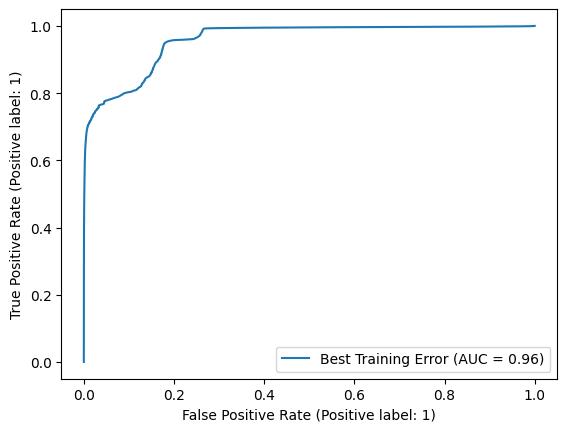

In [ ]:
#@title Plotting AUC Curves

def plot_auc(model, test_loader, name):
  y_pred, y_true = inference(model, test_loader, device)
  y_true, y_pred = np.ndarray.flatten(y_true), np.ndarray.flatten(y_pred)
  auc_score = sk.roc_auc_score(y_true, y_pred)
  print(f"AUC Score: {auc_score}")
  sk.RocCurveDisplay.from_predictions(y_true, y_pred, name=name)

plot_auc(best_err_model, test_loader, "Best Training Error")

AUC Score: 0.9581195044395248


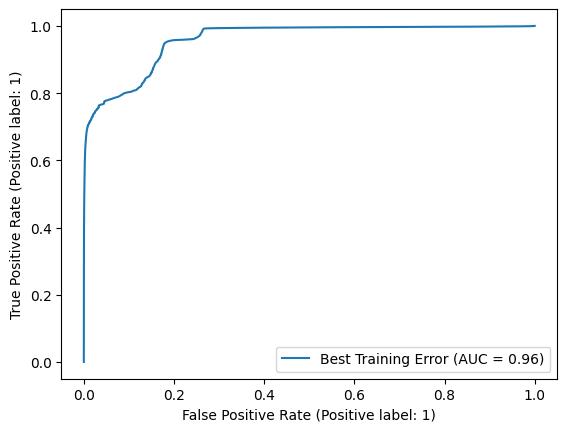

In [ ]:
#@title Plotting AUC Curves

def plot_auc(model, test_loader, name):
  y_pred, y_true = inference(model, test_loader, device)
  y_true, y_pred = np.ndarray.flatten(y_true), np.ndarray.flatten(y_pred)
  auc_score = sk.roc_auc_score(y_true, y_pred)
  print(f"AUC Score: {auc_score}")
  sk.RocCurveDisplay.from_predictions(y_true, y_pred, name=name)

plot_auc(best_auc_model, test_loader, "Best Training Error")

# Grid Search

In [ ]:
def train_model(batch_size, depth, initial_channel_size, dropout):
  model = UNet(
        depth=depth,
        initial_channel_size=initial_channel_size,
        dropout=dropout,
    ).to(device)

  criterion = nn.BCELoss()
  optimizer = torch.optim.Adadelta(params=model.parameters())

  _, _, model = run(model, 2, train_loader, criterion, optimizer, results_file,
              MODEL_PATH=model_file, test_loader=test_loader)

  prediction = model(val_dataset)
  loss = criterion(prediction, val_labels)

  return model, loss

param_grid = {
  'batch_size': [16, 32, 64, 128],
  'depth': [2, 3],
  'initial_channel_size': [64, 96, 128, 256],
  'dropout': [0.2, 0.3, 0.5, 0.6]
}

best_loss = torch.inf
best_hyperparameters = {}

for batch_size in param_grid['batch_size']:
  for depth in param_grid['depth']:
    for initial_channel_size in param_grid['initial_channel_size']:
      for dropout in param_grid['dropout']:
        model, loss = train_model(batch_size, depth, initial_channel_size, dropout)

        print('the loss of the model is: ', loss)
        # Update the best hyperparameters if the current model is better
        if loss < best_loss:
            best_loss = loss
            best_hyperparameters = {'batch_size': batch_size, 'depth': depth, 'initial_channel_size': initial_channel_size, 'dropout': dropout}
            print(best_hyperparameters)
            torch.save(model, ''+f'grid_search/b_s={batch_size},dep={depth},init_c_s={initial_channel_size},do={dropout}')
        del model, loss